#### Feature selection for INSS. Stage

In [1]:
#Load the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

In [2]:
#En son veriler
X_train=pd.read_csv("X_train.csv", index_col="ID")
X_test=pd.read_csv("X_test.csv", index_col="ID")
y_train=pd.read_csv("y_train.csv", index_col="ID")
y_test=pd.read_csv("y_test.csv", index_col="ID")

In [4]:
y_train["INSS.Stage"].value_counts()

INSS.Stage
4     151
1      96
4S     39
3       9
2       3
Name: count, dtype: int64

In [3]:
from sklearn.preprocessing import LabelEncoder
# #only get one target
y_inss=y_train["INSS.Stage"]

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the class labels to numeric values
y_inss_encode = label_encoder.fit_transform(y_inss)

# Now, if you want to get the original labels from the encoded values:
original_labels = label_encoder.inverse_transform(y_inss_encode)

In [46]:
original_labels

array(['4', '4S', '1', '4', '4', '4', '1', '1', '1', '4S', '4', '4', '1',
       '4', '1', '4', '1', '4', '4', '4', '4', '4', '4S', '1', '4S', '1',
       '4', '1', '4', '4', '4S', '4', '4', '4', '4S', '1', '4', '4', '4',
       '1', '3', '1', '1', '4', '4', '4', '4', '1', '1', '4', '1', '4',
       '3', '4', '1', '3', '4', '1', '4', '4', '1', '4', '4S', '1', '1',
       '4S', '1', '1', '4', '4', '4S', '1', '4', '4', '4', '4', '4S', '1',
       '1', '3', '4', '4', '1', '4', '1', '4', '4', '2', '1', '4S', '4S',
       '2', '3', '4', '4S', '4', '4', '4', '4S', '4', '1', '4', '4', '4S',
       '1', '1', '4', '4', '1', '1', '4', '4', '4', '1', '4', '4S', '4',
       '1', '4', '1', '3', '1', '4', '4', '4', '4', '4', '4S', '3', '4S',
       '4', '1', '4S', '4', '1', '1', '1', '4', '1', '4', '4S', '4', '4',
       '1', '4', '4S', '4S', '4S', '4', '1', '1', '4', '4', '4', '4', '4',
       '1', '1', '4', '4', '4', '1', '4', '4', '4', '4', '4S', '1', '1',
       '4', '4', '4', '4', '4', '1', '1'

In [26]:
#INSS is associated with INSS therefore don't put this in feature matrix
excluded_features = ["clinico.genetic.subgroup_MNA","clinico.genetic.subgroup_ST1","clinico.genetic.subgroup_ST4", "clinico.genetic.subgroup_ST4S"]
X=X_train.loc[:, ~X_train.columns.isin(excluded_features)]
y=y_inss_encode.copy()

#### Random Forest Feature selection

In [27]:
# Import necessary libraries
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif, SelectPercentile
from sklearn.model_selection import KFold, StratifiedKFold, StratifiedGroupKFold
from sklearn.metrics import accuracy_score, f1_score

skf = StratifiedKFold(n_splits=5)

rf = RandomForestClassifier()

# Initialize lists to store accuracy and F1 scores for each fold
accuracy_scores = []
f1_scores = []

## Number of top features
top_k = 300

# Initialize list to hold common features from each fold
common_features = []

# Iterate over each split
# Iterate over each split
for train_index, test_index in skf.split(X, y):
    X_train_temp, X_test_temp = X.iloc[train_index], X.iloc[test_index]  
    y_train_temp, y_test_temp = y[train_index], y[test_index]

    # Initialize feature selectors
    selector_kbest = SelectKBest(score_func=f_classif, k=top_k)  # Adjust 'k' as per your requirements
    selector_percentile = SelectPercentile(score_func=f_classif, percentile=1)
    
    # Fit and transforX_train, y_trainm the data
    X_new_kbest = selector_kbest.fit_transform(X_train_temp, y_train_temp)
    X_new_percentile = selector_percentile.fit_transform(X_train_temp, y_train_temp)
    
    # Get the selected features
    selected_features_kbest = X_train_temp.columns[selector_kbest.get_support()]
    selected_features_percentile = X_train_temp.columns[selector_percentile.get_support()]
    
    # Get the common features and add to the list
    common_features_fold = set(selected_features_kbest) & set(selected_features_percentile)
    common_features.append(common_features_fold)
    #print("Common Features in thi Fold : ", common_features_fold )

    # Train the model on the selected features and compute the accuracy
    X_train_selected = X_train_temp[list(common_features_fold)]
    X_test_selected = X_test_temp[list(common_features_fold)]
    rf.fit(X_train_selected, y_train_temp)
    y_pred = rf.predict(X_test_selected)

     # Calculate accuracy
    accuracy = accuracy_score(y_test_temp, y_pred)
    
    # Calculate F1 score
    f1 = f1_score(y_test_temp, y_pred, average="weighted")

    print(f'Accuracy for this fold: {accuracy}')
    print(f'F1 score for this fold: {f1}')

    # Append scores to the lists
    accuracy_scores.append(accuracy)
    f1_scores.append(f1)

# Calculate the mean accuracy and F1 score
mean_accuracy = sum(accuracy_scores) / len(accuracy_scores)
mean_f1_score = sum(f1_scores) / len(f1_scores)

print(f'Mean Accuracy: {mean_accuracy}')
print(f'Mean F1 Score: {mean_f1_score}')


# Get the intersection of common features from all folds
final_common_features = set.intersection(*map(set, common_features))

print(f"Final common features: {final_common_features}")



c:\Users\isile\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Accuracy for this fold: 0.7333333333333333
F1 score for this fold: 0.6958333333333332
Accuracy for this fold: 0.7833333333333333
F1 score for this fold: 0.7045102184637069
Accuracy for this fold: 0.7333333333333333
F1 score for this fold: 0.692910447761194
Accuracy for this fold: 0.7627118644067796
F1 score for this fold: 0.7181994998610725
Accuracy for this fold: 0.711864406779661
F1 score for this fold: 0.6751779294152175
Mean Accuracy: 0.7449152542372881
Mean F1 Score: 0.6973262857669048
Final common features: {'Unnamed: 10293', 'Unnamed: 27244', 'Unnamed: 23848', 'Unnamed: 9100', 'Unnamed: 12780', 'Unnamed: 20557', 'Unnamed: 3572', 'Unnamed: 36445', 'Unnamed: 20215', 'Unnamed: 10440', 'Unnamed: 21866', 'YPEL1', 'Unnamed: 11471', 'Unnamed: 7357', 'Unnamed: 40711', 'Unnamed: 41668', 'PDLIM5', 'PNPLA5', 'Unnamed: 21800', 'Unnamed: 39693', 'Unnamed: 32028', 'Unnamed: 3564', 'Unnamed: 19017', 'Unnamed: 10992', 'Unnamed: 8198', 'Unnamed: 27503', 'Unnamed: 9105', 'GPNMB.1', 'Unnamed: 2886

In [28]:
# # Convert the set to a DataFrame
# final_common_features_df = pd.DataFrame(final_common_features, columns=["FeatureName"])

# # Save it to a CSV file
# final_common_features_df.to_csv("final_common_features_for_INSS.csv", index=False)

In [29]:
# final_common_features_df

After feature selection none of the clinical features were selected. I maybe try to use some of them but taking care of oversampling or outliers
Be careful about clinico genetic subgroup for INSS, We cannot use it due to redundancy.

COMMON SELECTED FEATURES AMONG CLINICAL ENDPOINTS

In [55]:
import csv
selected_features_inss = pd.read_csv("final_common_features_for_INSS.csv",index_col=False)
selected_features_hr = pd.read_csv("final_common_features_for_HighRisk.csv",index_col=False)
selected_features_prog = pd.read_csv("final_common_features_for_Progression.csv",index_col=False)
selected_features_death = pd.read_csv("final_common_features_for_DeathFromDisease.csv",index_col=False)

feature_dataframes=[selected_features_inss,selected_features_hr,selected_features_prog,selected_features_death]
# Initialize a list to store the common features for all pairs
common_features_list = []

# Compare each pair of dataframes using nested loops
for i in range(len(feature_dataframes)):
    for j in range(i + 1, len(feature_dataframes)):
        df1 = feature_dataframes[i]
        df2 = feature_dataframes[j]

        # Find common features between the current pair of dataframes
        common_features = set(df1["FeatureName"]).intersection(df2["FeatureName"])

        # Append the common features to the list
        common_features_list.append([f"Dataframes {i+1} and {j+1}", ",".join(common_features)])

# Save the common features list to a CSV file
with open("common_selected_features_list.csv", "w", newline="") as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(["Pair", "Common Features"])
    csv_writer.writerows(common_features_list)

####  RANDOM FOREST FEATURE IMPORTANCE

c:\Users\isile\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


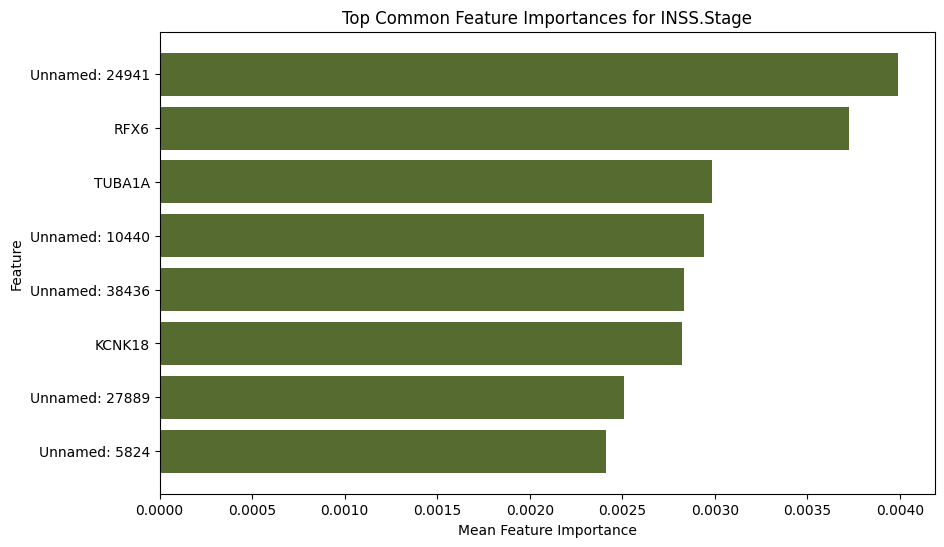

In [68]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import numpy as np

# Initialize a Random Forest Classifier
rfc = RandomForestClassifier(random_state=42)

# Initialize lists to store feature importances for each fold
feature_importances = []

# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=5)

# Iterate over each split
for train_index, test_index in skf.split(X, y):
    X_train_temp, X_test_temp = X.iloc[train_index], X.iloc[test_index]
    y_train_temp, y_test_temp = y[train_index], y[test_index]

    # Fit the Random Forest Classifier
    rfc.fit(X_train_temp, y_train_temp)

    # Get feature importances from the trained model
    importances = rfc.feature_importances_
    feature_importances.append(importances)

# Calculate the mean feature importances across all folds
mean_feature_importances = np.mean(feature_importances, axis=0)

# Sort the common features by their corresponding importances in descending order
sorted_common_features = [X.columns[feature] for feature in sorted(common_features, key=lambda x: mean_feature_importances[x], reverse=False)]

# Select the top N common features (e.g., top 100 features)
num_top_features = 100
top_common_features = sorted_common_features[:num_top_features]

# Plot the top common feature importances in a horizontal bar chart
plt.figure(figsize=(10, 6))
plt.barh(range(len(top_common_features)), [mean_feature_importances[X.columns.get_loc(feature)] for feature in top_common_features], align="center", color="darkolivegreen")
plt.yticks(range(len(top_common_features)), top_common_features)
plt.xlabel("Mean Feature Importance")
plt.ylabel("Feature")
plt.title("Top Common Feature Importances for INSS.Stage")
plt.show()





#### Hyperparameter tuning

##### Set the X and y

In [4]:
####X feature matrix
#### Import selected features for INSS
selected_features_inss = pd.read_csv("final_common_features_for_INSS.csv",index_col=False)
##
#### Put them in a list
selected_features = selected_features_inss['FeatureName'].tolist()

# Subset X_train to include only the selected features
X_sub_inss = X_train[selected_features]
X_sub_inss

# y y_inss_encode

,ESR1.2,Unnamed: 9273,DOLK,MTMR9LP,E2F3,Unnamed: 25946,Unnamed: 7357,Unnamed: 41369,Unnamed: 8332,SLC5A4-AS1|CPSF1,...,Unnamed: 10293,Unnamed: 378,Unnamed: 17674,Unnamed: 10275,Unnamed: 18278,Unnamed: 3564,Unnamed: 19017,Unnamed: 11034,Unnamed: 5682,Unnamed: 28860
ID,,,,,,,,,,,,,,,,,,,,,
ICGC_466,0.088675,0.374905,-0.353182,0.493617,0.412768,0.067744,0.450173,-0.466201,-1.310932,0.461749,...,-0.268176,-0.520172,0.947308,0.236972,0.772771,-1.821835,0.149382,1.134327,-0.288519,0.349698
ICGC_292,0.401301,-0.714407,-0.128004,0.187416,0.336705,0.419965,-0.235063,0.220557,1.097063,0.135441,...,0.110909,-0.635048,-0.635356,-0.005921,-0.272603,0.225096,0.350147,0.050565,-0.656489,-0.298251
ICGC_032,0.771515,0.717610,0.889800,0.921143,0.510564,0.381366,0.840685,0.841910,0.971476,0.628788,...,0.507627,0.566727,1.145140,0.579881,0.081475,-0.062990,0.114634,0.392501,0.116247,1.039450
ICGC_408,0.713926,-1.791480,-0.605381,-0.580976,-1.309519,-0.853822,-2.187620,-0.963283,-0.000458,-2.393452,...,-1.669913,0.010023,-0.566114,-0.477421,-0.373768,-0.745301,-0.468357,-0.140687,-2.096827,-1.338104
ICGC_108,0.787969,-0.261547,0.457458,0.210525,0.548595,-0.168679,0.125975,0.377530,0.774905,0.341326,...,0.401836,-0.219728,0.027385,0.165533,-0.120855,0.308490,0.929277,-0.256598,0.804876,0.307895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ICGC_309,0.376620,0.044440,0.142210,0.770931,1.162534,0.458565,0.192289,0.626072,0.742144,0.850212,...,0.172621,0.151408,0.403267,0.286980,0.115197,0.482858,0.365590,1.285010,0.142531,0.485558
ICGC_371,-1.194736,-0.102434,0.133202,0.510949,-0.646683,-0.458176,-0.154014,-0.695121,0.359922,-0.256907,...,0.534075,0.098389,-0.210015,0.658464,0.266945,-0.396564,0.114634,0.050565,-0.299033,-0.549070
ICGC_107,1.380313,1.329584,0.736679,1.417998,0.347571,0.960360,1.489081,0.220557,0.220684,1.032789,...,0.842633,1.132268,1.026441,0.422715,0.789632,1.438093,0.373312,1.087963,1.698516,0.318346


### HYPERPARAMETER TUNING

In [5]:
#Import necessary libraries
from sklearn.model_selection import  GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, auc, precision_recall_curve, average_precision_score

##############FOR RANDOM FOREST-HYPER PARAMETER TUNING#########################

# Set the parameters for grid search (for Random Forest) #we can give choices inside in list as much as we want
param_grid = {
    'n_estimators': [100, 200, 300], 
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10]#choices 2,5 and 10
}

# Initialize a RandomForestClassifier (define the Random Forest classifier)
rf = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV (define the grid search algorithm)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5) #here in param_grid ,we provide the param_grid that we set above

# Fit GridSearchCV
grid_search.fit(X_sub_inss, y_inss)
#during grid search for train set, every possible combinations of the parameter choices that we set above will be tested.
#And for ever single parameter combination, it will run cross_validation for 5 folds

#after that we obtain the best parameters from the grid search

# Get the best parameters (for the random forest)
best_params = grid_search.best_params_
print('Best parameters for RandomForestClassifier: ', best_params)

c:\Users\isile\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Best parameters for RandomForestClassifier:  {'max_depth': 7, 'min_samples_split': 2, 'n_estimators': 300}


In [36]:
#import the train-test split library
from sklearn.model_selection import train_test_split
#X_subset_inss, y_inss


#Split the data (20% for test, because we have small dataset)
X_train_inss, X_test_inss, y_train_inss, y_test_inss = train_test_split(X_sub_inss, y_inss_encode, test_size=0.2, random_state=1)

#Check the dimensions of the data


#### Stratified Cross-Validation on X_train for multiclass INSS.Stage clinical endpoint, after hyperparameter tuning (cv=3) because stage2 has only 3 samples

Conducting a 3-fold cross-validation on the training dataset after hyperparameter tuning is a prudent approach in machine learning. This practice allows to evaluate the model's generalization performance within the training dataset without risking data leakage from the reserved test data. In addition CV provides a valuable assessment of how well your model performs across different subsets of the training data and seeing the anomalies on the data which offering a reasonable estimate of its potential performance on unseen data. Moreover, comparing the cross-validation results to the initial single random split helps me estimate the consistency of your model's performance and builds confidence in the reliability of that single split. In otherwords, I have performed the train and test split from original data and I have one split for trainset only but in order to understand how this split reflects the overall dataset, this approach is very valuable.


Confusion Matrix for Fold 0 with INSS.Stages:
     1  2  3   4  4S
1   30  0  0   2   0
2    0  0  0   1   0
3    0  0  0   3   0
4    5  0  0  46   0
4S   7  0  0   5   1
Confusion Matrix for Fold 1 with INSS.Stages:
     1  2  3   4  4S
1   28  0  0   4   0
2    0  0  0   1   0
3    0  0  0   3   0
4    6  0  0  44   0
4S   8  0  0   3   2
Confusion Matrix for Fold 2 with INSS.Stages:
     1  2  3   4  4S
1   27  0  0   5   0
2    0  0  0   1   0
3    0  0  0   3   0
4    2  0  0  48   0
4S   8  0  0   4   1
Mean Accuracy: 0.7617171717171717
Mean Precision: 0.7617171717171717
Mean Recall: 0.7617171717171717
Mean F1-score: 0.7617171717171717
Mean ROC-AUC: 0.9362961730095568
Mean PR-AUC: 0.8007101157985114


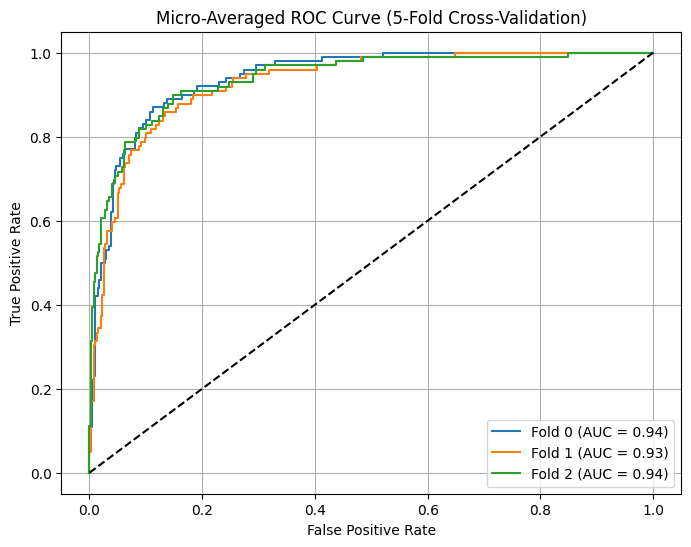

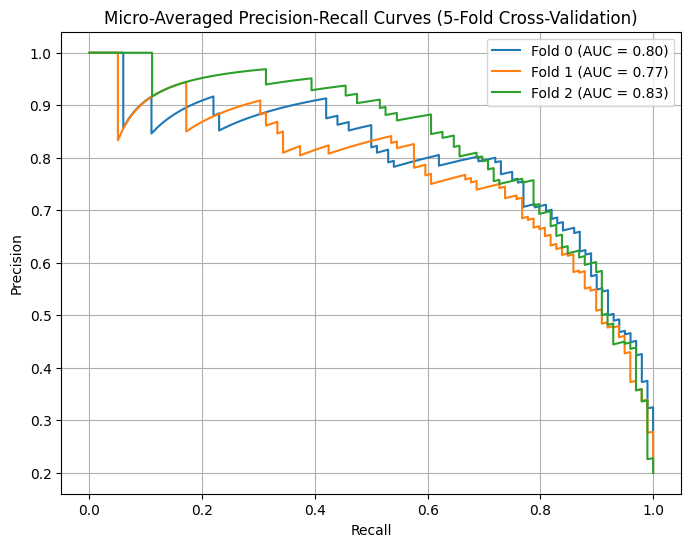

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score,confusion_matrix
from sklearn.model_selection import StratifiedKFold
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Create a Random Forest classifier
clf = RandomForestClassifier(**best_params, random_state=42)

# Define the number of folds for cross-validation
n_splits = 3

# Initialize lists to store metrics for each fold
accuracies = []
precisions = []
recalls = []
f1_scores = []
roc_aucs = []
pr_aucs = []

# Initialize variables for mean ROC-AUC and PR-AUC
mean_roc_auc = 0
mean_pr_auc = 0

# Initialize lists to store ROC and PR curves for each fold
roc_curves = []

# Initialize lists to store recall and precision values for each fold
recall_values = []
precision_values = []

# Initialize the list to store confusion matrices for each fold
confusion_matrices = []

# Create a StratifiedKFold object for cross-validation
skf = StratifiedKFold(n_splits=n_splits)

for train_index, test_index in skf.split(X_sub_inss.values, y_inss_encode):
    X_train, X_test = X_sub_inss.iloc[train_index], X_sub_inss.iloc[test_index]
    y_train, y_test = y_inss_encode[train_index], y_inss_encode[test_index]

    # Train the Random Forest classifier
    clf.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred_probs = clf.predict_proba(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Calculate accuracy, precision, recall, and F1-score
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='micro')
    recall = recall_score(y_test, y_pred, average='micro')
    f1 = f1_score(y_test, y_pred, average='micro')

    # Store the metrics for this fold
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

    # Calculate ROC-AUC for this fold
    y_true_binary = np.zeros_like(y_pred_probs)
    y_true_binary[np.arange(y_pred_probs.shape[0]), y_test] = 1
    fpr, tpr, _ = roc_curve(y_true_binary.ravel(), y_pred_probs.ravel())
    roc_auc = roc_auc_score(y_true_binary.ravel(), y_pred_probs.ravel())
    roc_aucs.append(roc_auc)
    roc_curves.append((fpr, tpr))

    # Calculate and append the confusion matrix for this fold
    conf_matrix = confusion_matrix(y_test, y_pred)
    confusion_matrices.append(conf_matrix)


    # Calculate Precision-Recall values for this fold
    precision_fold, recall_fold, _ = precision_recall_curve(y_true_binary.ravel(), y_pred_probs.ravel())
    recall_values.append(recall_fold)
    precision_values.append(precision_fold)

    # Calculate PR-AUC for this fold
    pr_auc = average_precision_score(y_true_binary.ravel(), y_pred_probs.ravel())
    pr_aucs.append(pr_auc)

    # Update mean ROC-AUC and PR-AUC
    mean_roc_auc += roc_auc
    mean_pr_auc += pr_auc

# Calculate mean ROC-AUC and PR-AUC across folds
mean_roc_auc /= n_splits
mean_pr_auc /= n_splits

# Obtain unique class labels from y_test_inss
class_labels = class_labels = ['1', '2', '3', '4', '4S']

# Print the confusion matrices for each fold
for i, conf_matrix in enumerate(confusion_matrices):
    confusion_matrix_df = pd.DataFrame(conf_matrix, index=class_labels, columns=class_labels)
    print(f"Confusion Matrix for Fold {i} with INSS.Stages:")
    print(confusion_matrix_df)

# Print the mean metrics across folds
print("Mean Accuracy:", np.mean(accuracies))
print("Mean Precision:", np.mean(precisions))
print("Mean Recall:", np.mean(recalls))
print("Mean F1-score:", np.mean(f1_scores))
print("Mean ROC-AUC:", mean_roc_auc)
print("Mean PR-AUC:", mean_pr_auc)

# Plot the ROC curve for each fold and the mean ROC-AUC
plt.figure(figsize=(8, 6))
for i, (fpr, tpr) in enumerate(roc_curves):
    roc_auc = roc_aucs[i]
    plt.plot(fpr, tpr, label=f'Fold {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-Averaged ROC Curve (5-Fold Cross-Validation)')
plt.legend(loc='best')
plt.grid()
plt.show()

# Plot the Precision-Recall curves for each fold
plt.figure(figsize=(8, 6))
for i, (recall, precision) in enumerate(zip(recall_values, precision_values)):
    pr_auc = pr_aucs[i]
    plt.plot(recall, precision, label=f'Fold {i} (AUC = {pr_auc:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Micro-Averaged Precision-Recall Curves (5-Fold Cross-Validation)')
plt.legend(loc='best')
plt.grid()
plt.show()


In [10]:

!pip install --quiet optuna

import optuna

optuna.__version__

ModuleNotFoundError: No module named 'optuna'

In [9]:
pip show optuna

Note: you may need to restart the kernel to use updated packages.


SINGLE MODEL EVALUATION FOR MULTICLASS CLINICAL ENDPOINT(INSS.STAGE)

In [96]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_curve, roc_auc_score,average_precision_score
import numpy as np
import pandas as pd
%matplotlib inline


# Create a Random Forest classifier
clf = RandomForestClassifier(**best_params, random_state=42)  # You can adjust parameters as needed

# Train the Random Forest classifier
clf.fit(X_train_inss, y_train_inss)

# Make predictions on the test set
y_pred_probs = clf.predict_proba(X_test_inss)  # Predict probabilities for all classes

# Calculate accuracy using scikit-learn's accuracy_score
y_pred = np.argmax(y_pred_probs, axis=1)  # Get the predicted class labels
accuracy = accuracy_score(y_test_inss, y_pred)
print("Accuracy:", accuracy)

# Calculate precision, recall, and F1-score
precision = precision_score(y_test_inss, y_pred, average='micro')
recall = recall_score(y_test_inss, y_pred, average='micro')
f1 = f1_score(y_test_inss, y_pred, average='micro')

# Print the precision,recall and f1 
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

# Obtain unique class labels from y_test_inss
class_labels = class_labels = ['1', '2', '3', '4', '4S']#np.unique(y_test_inss)

# Combine the predicted probabilities into a single array
y_combined = np.vstack(y_pred_probs)

# Create binary true labels, where the positive class is 1 and all other classes are 0
y_true_binary = np.zeros_like(y_combined)
y_true_binary[np.arange(y_combined.shape[0]), y_test_inss] = 1

# Compute micro-averaged ROC curve and AUC
fpr, tpr, _ = roc_curve(y_true_binary.ravel(), y_combined.ravel())
micro_roc_auc = roc_auc_score(y_true_binary.ravel(), y_combined.ravel())

# Calculate PR-AUC for each class
pr_auc_per_class = average_precision_score(y_true_binary, y_pred_probs, average=None)
# Calculate micro-averaged PR-AUC
micro_pr_auc = average_precision_score(y_true_binary, y_pred_probs, average='micro')

# Print the PR-AUC for each class and the micro-averaged PR-AUC
for class_label, pr_auc in zip(class_labels, pr_auc_per_class):
    print(f"PR-AUC for Class {class_label}: {pr_auc:.2f}")

print(f"Micro-Averaged PR-AUC: {micro_pr_auc:.2f}")

#Print the micro-averaged ROC AUC
print("Micro-Averaged ROC AUC:", micro_roc_auc)

# Calculate and print the confusion matrix
conf_matrix = confusion_matrix(y_test_inss, y_pred)
confusion_matrix_df = pd.DataFrame(conf_matrix, index=class_labels, columns=class_labels)
print("Confusion Matrix with INSS.Stages:")
print(confusion_matrix_df)


# Compute micro-averaged ROC and PR
fpr_micro, tpr_micro, _ = roc_curve(y_true_binary.ravel(), y_pred_probs.ravel())
precision_micro, recall_micro, _ = precision_recall_curve(y_true_binary.ravel(), y_pred_probs.ravel())

# Plot the micro-averaged ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_micro, tpr_micro, label=f'Micro-Averaged ROC (AUC = {micro_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-Averaged ROC Curve')
plt.legend(loc='best')
plt.grid()
plt.show()

# Plot the micro-averaged PR curve
plt.figure(figsize=(8, 6))
plt.plot(recall_micro, precision_micro, label=f'Micro-Averaged PR (AUC = {micro_pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Micro-Averaged Precision-Recall Curve')
plt.legend(loc='best')
plt.grid()
plt.show()



#For each subclass
# # Plot the ROC curve
# plt.figure(figsize=(8, 6))
# for i in range(len(class_labels)):
#     fpr, tpr, _ = roc_curve(y_true_binary[:, i], y_pred_probs[:, i])
#     plt.plot(fpr, tpr, label=f'ROC-AUC for INSS.Stages {class_labels[i]}')

# plt.plot([0, 1], [0, 1], 'k--')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve')
# plt.legend(loc='best')
# plt.grid()
# plt.show()

# # Plot the PR curve
# plt.figure(figsize=(8, 6))
# for i in range(len(class_labels)):
#     precision, recall, _ = precision_recall_curve(y_true_binary[:, i], y_pred_probs[:, i])
#     plt.plot(recall, precision, label=f'PR-AUC for INSS.Stages {class_labels[i]}')

# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.title('Precision-Recall Curve')
# plt.legend(loc='best')
# plt.grid()
# plt.show()




0.8129970893201472

In [29]:
#import the train-test split library
from sklearn.model_selection import train_test_split
#X_subset_inss, y_inss_encode


#Split the data (20% for test, because we have small dataset)
X_train, X_test, y_train, y_test = train_test_split(X_subset_inss, y_inss_encode, test_size=0.2, random_state=1)

#Check the dimensions of the data


    Micro-Averaged Metrics:
        Micro-averaging gives more weight to larger classes, which can be helpful when you have class imbalance. If some classes are much smaller than others, micro-averaged metrics provide a better overall assessment of the model's performance.
        It's suitable when you want to evaluate the model's performance as a whole, without considering class sizes.

    Macro-Averaged Metrics:
        Macro-averaging treats all classes equally and calculates the metric independently for each class. It provides an overall measure of model performance that doesn't give preference to larger classes.
        It's suitable when you want to assess the model's ability to perform well on each class independently, without being influenced by class imbalance.

Which one to choose depends on the context of your problem and what you consider more important. Here are some considerations to help you decide:

    Use Micro-Averaging When:
        Class sizes vary significantly.
        You want an overall assessment of the model's performance across all classes, with more weight given to larger classes.
        You want to measure how well the model handles rare classes or highly imbalanced datasets.

    Use Macro-Averaging When:
        You want to evaluate the model's ability to perform well on each class independently, regardless of class sizes.
        All classes are considered equally important.
        You want to identify classes where the model's performance may need improvement.

In [193]:
unique_class_labels = y_inss.unique()
print("Class Labels in the Dataset:")
for label in unique_class_labels:
    print(label)

Class Labels in the Dataset:
4
4S
1
3
2


    Class 1: The model correctly predicted 15 instances as class 1, but it incorrectly predicted 5 instances as class 4. It also incorrectly predicted 3 instances from class 4 as class 1.

    Class 2: The model didn't correctly predict any instances as class 2, and there was no confusion with other classes.

    Class 3: The model didn't correctly predict any instances as class 3, and there was no confusion with other classes.

    Class 4: The model correctly predicted 28 instances as class 4, but it incorrectly predicted 5 instances as class 1. It also incorrectly predicted 3 instances from class 1 as class 4. It correctly predicted 1 instance as class 5.

    Class 5: The model correctly predicted 1 instance as class 5, but it incorrectly predicted 5 instances as class 1.